In [1]:
import numpy as np 
import pandas as pd
import re
import nltk
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.stem.lancaster import LancasterStemmer
lc = LancasterStemmer()
from nltk.stem import SnowballStemmer
sb = SnowballStemmer("english")
from nltk.corpus import stopwords
import string as s
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
import spacy
import os
import gc
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPooling1D, Concatenate, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import Constant
import pickle
import seaborn as sns
sns.set_style("white")

/Users/faith/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/faith/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/faith/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])

In [2]:
train_df=pd.read_csv('/Users/faith/Downloads/nlp-getting-started/train.csv')
test_df=pd.read_csv('/Users/faith/Downloads/nlp-getting-started/test.csv')

# Data Information in train and test files
def data_info(d):
    print('number of variables: ',d.shape[1])
    print('number of tweets: ',d.shape[0])
    print('variables names: ')
    print(d.columns)
    print('variables data-types: ')
    print(d.dtypes)
    print('missing values: ')
    c=d.isnull().sum()
    print(c[c>0])

In [3]:
data_info(train_df)

number of variables:  5
number of tweets:  7613
variables names: 
Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
variables data-types: 
id           int64
keyword     object
location    object
text        object
target       int64
dtype: object
missing values: 
keyword       61
location    2534
dtype: int64


In [4]:
data_info(test_df)

number of variables:  4
number of tweets:  3263
variables names: 
Index(['id', 'keyword', 'location', 'text'], dtype='object')
variables data-types: 
id           int64
keyword     object
location    object
text        object
dtype: object
missing values: 
keyword       26
location    1105
dtype: int64


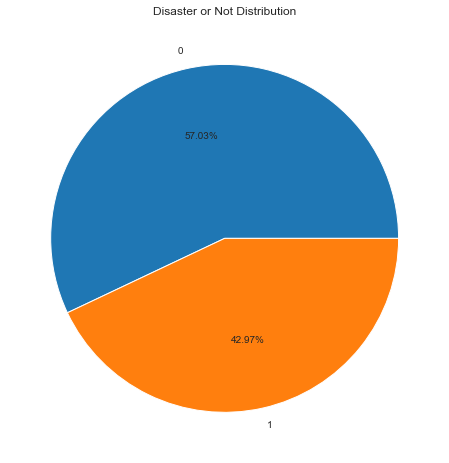

In [5]:
#Graphical display of information distribution
plt.figure(figsize=(8,8))
train_df['target'].value_counts().plot.pie(autopct='%.2f%%')
plt.title('Disaster or Not Distribution')
plt.ylabel('')
plt.show()

In [6]:
train_text = train_df['text']
test_text = test_df['text']
target = train_df['target'].values

# combine the text from the training dataset and the test dataset
text_list = pd.concat([train_text, test_text])

# number of training samples
num_train_data = target.shape[0]

In [7]:
text_list = text_list.apply(lambda x: re.sub('&amp;', ' and ', x))
text_list = text_list.apply(lambda x: re.sub('w/', 'with', x))

In [8]:
# preprocessing by using spacy
nlp = spacy.load('en_core_web_lg')
nlp.vocab.add_flag(lambda s: s.lower() in spacy.lang.en.stop_words.STOP_WORDS, spacy.attrs.IS_STOP)
docs = nlp.pipe(text_list, n_threads = 2)

# convert words to integers and save the results in word_sequences
word_sequences = []

# store the mapping in word_dict
word_dict = {}
lemma_dict = {}

# store the frequence of each word
word_freq = {}

word_index = 1
for doc in docs:
    word_seq = []
    for word in doc:
        try:
            word_freq[word.text] += 1
        except KeyError:
            word_freq[word.text] = 1
        if (word.text not in word_dict) and (word.pos_ is not 'PUNCT'):
            word_dict[word.text] = word_index
            word_index += 1
            lemma_dict[word.text] = word.lemma_
            
        # do not include punctuations in word_dict
        # this essentially removes hashtags and mentions
        if word.pos_ is not 'PUNCT':
            word_seq.append(word_dict[word.text])
    word_sequences.append(word_seq)
del docs
gc.collect()

# maximum number of words per tweet in the dataset
max_length = max([len(s) for s in word_sequences])

# number of unique words
# add 1 because 0 is reserved for padding
vocab_size = len(word_dict) + 1

train_word_sequences = word_sequences[:num_train_data]
test_word_sequences = word_sequences[num_train_data:]

# add zeros at the end of each word sequence so that their lengths are fixed at max_len
train_word_sequences = pad_sequences(train_word_sequences, maxlen=max_length, padding='post')
test_word_sequences = pad_sequences(test_word_sequences, maxlen=max_length, padding='post')

In [9]:
#embedding_matrix
def load_embeddings(embeddings_index, word_dict, lemma_dict):
    embed_size = 300
    vocab_size = len(word_dict) + 1
    embedding_matrix = np.zeros((vocab_size, embed_size), dtype=np.float32)
    unknown_vector = np.zeros((embed_size,), dtype=np.float32) - 1.
    for key in word_dict:
        word = key
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.lower()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.upper()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.capitalize()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = ps.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = lc.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = sb.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = lemma_dict[key]
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        embedding_matrix[word_dict[key]] = unknown_vector                    
    return embedding_matrix

In [10]:
def load_pickle_file(path):
    with open(path, 'rb') as f:
        file = pickle.load(f)
    return file

# the asterisk below allows the function to accept an arbitrary number of inputs
# convert the embedding file into a Python dictionary
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

#train word vector by using glove                                                  
path_glove = '/Users/faith/Downloads/glove.840B.300d.pkl'
path_paragram = '/Users/faith/Downloads/paragram_300_sl999.txt'

embeddings_index_glove = load_pickle_file(path_glove)
# the asterisks below unpacks the list
embeddings_index_paragram = dict(get_coefs(*o.split(" ")) for o in open(path_paragram, encoding="utf8", errors='ignore') if len(o) > 100)

embedding_matrix_glove = load_embeddings(embeddings_index_glove, word_dict, lemma_dict)
embedding_matrix_paragram = load_embeddings(embeddings_index_paragram, word_dict, lemma_dict)

# stack the two pre-trained embedding matrices
embedding_matrix = np.concatenate((embedding_matrix_glove, embedding_matrix_paragram), axis=1)

In [11]:
embedding_size = 600
learning_rate = 0.001
batch_size = 32
num_epoch = 5

#build model
def build_model(embedding_matrix, vocab_size, max_length, embedding_size=300):
    model = Sequential([
        Embedding(vocab_size, embedding_size, embeddings_initializer=Constant(embedding_matrix), 
                  input_length=max_length, trainable=False),
        SpatialDropout1D(0.3),
        Bidirectional(LSTM(128, return_sequences=True)),
        Conv1D(64, kernel_size=2), 
        GlobalMaxPooling1D(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [12]:
reps = 5
pred_prob = np.zeros((len(test_word_sequences),), dtype=np.float32)
for r in range(reps):
    model = build_model(embedding_matrix, vocab_size, max_length, embedding_size)
    model.fit(train_word_sequences, target, batch_size=batch_size, epochs=num_epoch, verbose=2)
    pred_prob += np.squeeze(model.predict(test_word_sequences, batch_size=batch_size, verbose=2) / reps)

Epoch 1/5
 - 31s - loss: 0.4662 - acc: 0.7867
Epoch 2/5
 - 28s - loss: 0.3933 - acc: 0.8299
Epoch 3/5
 - 27s - loss: 0.3503 - acc: 0.8499
Epoch 4/5
 - 26s - loss: 0.3091 - acc: 0.8689
Epoch 5/5
 - 27s - loss: 0.2678 - acc: 0.8914
Epoch 1/5
 - 36s - loss: 0.4686 - acc: 0.7879
Epoch 2/5
 - 31s - loss: 0.3927 - acc: 0.8302
Epoch 3/5
 - 27s - loss: 0.3454 - acc: 0.8531
Epoch 4/5
 - 27s - loss: 0.3079 - acc: 0.8753
Epoch 5/5
 - 27s - loss: 0.2585 - acc: 0.8978
Epoch 1/5
 - 34s - loss: 0.4695 - acc: 0.7823
Epoch 2/5
 - 27s - loss: 0.3906 - acc: 0.8306
Epoch 3/5
 - 27s - loss: 0.3504 - acc: 0.8518
Epoch 4/5
 - 27s - loss: 0.3097 - acc: 0.8726
Epoch 5/5
 - 27s - loss: 0.2674 - acc: 0.8877
Epoch 1/5
 - 31s - loss: 0.4692 - acc: 0.7795
Epoch 2/5
 - 27s - loss: 0.3957 - acc: 0.8269
Epoch 3/5
 - 27s - loss: 0.3522 - acc: 0.8509
Epoch 4/5
 - 26s - loss: 0.3125 - acc: 0.8751
Epoch 5/5
 - 26s - loss: 0.2607 - acc: 0.8922
Epoch 1/5
 - 30s - loss: 0.4745 - acc: 0.7797
Epoch 2/5
 - 26s - loss: 0.3912 - 

In [22]:
submission = pd.read_csv('/Users/faith/Downloads/nlp-getting-started/sample_submission.csv')
submission['target'] = pred_prob.round().astype(int)
submission.to_csv('/Users/faith/Downloads/submission.csv', index=False)